In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Baseline Models

Simple baseline models to establish performance benchmarks before building complex models.

## Load Data

Data from the preprocessing notebook, already split 80/20 into train and test. All features are one-hot encoded and cleaned.

Train and test stay separate: training data learns patterns (bin statistics), test data stays untouched until final evaluation. Otherwise we can't measure actual generalization.

In [2]:
df_train = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_data.csv')

y_train = df_train['baseFare']
y_test = df_test['baseFare']
duration_train = df_train['travelDuration_minutes']
duration_test = df_test['travelDuration_minutes']

mean_price = y_train.mean()

print(f"Train: {len(df_train):,} rows | Test: {len(df_test):,} rows")

Train: 125,668 rows | Test: 31,418 rows


## Baseline 1: Equal-Width Binning

Split `travelDuration_minutes` range into 10 equal-width intervals (0-30 min, 30-60 min, etc.). Each bin gets the mean `baseFare` from training data as its prediction.

Equal-Width is the simplest binning approach - tests if duration alone predicts price. Extremely interpretable, provides a basic benchmark that any complex model should beat.

Problem: bins have unequal sample counts. With skewed distributions like flight durations, some bins have few samples → unstable means.

Bin statistics come only from training data. Using test data would leak information and inflate performance.

In [3]:
num_bins = 10
bin_edges = np.linspace(duration_train.min(), duration_train.max(), num_bins + 1)

bin_means = {}
for i in range(num_bins):
    mask = (duration_train >= bin_edges[i]) & (duration_train < bin_edges[i+1])
    if i == num_bins - 1:
        mask = (duration_train >= bin_edges[i]) & (duration_train <= bin_edges[i+1])
    bin_means[i] = y_train[mask].mean() if mask.sum() > 0 else mean_price

def predict_equal_width(duration):
    for i in range(num_bins):
        if i == num_bins - 1:
            if duration >= bin_edges[i] and duration <= bin_edges[i+1]:
                return bin_means[i]
        else:
            if duration >= bin_edges[i] and duration < bin_edges[i+1]:
                return bin_means[i]
    return mean_price

Metric Calculations

In [4]:
y_pred_equal_width_log = duration_test.apply(predict_equal_width)

y_test_actual = np.expm1(y_test)

y_pred_equal_width = np.expm1(y_pred_equal_width_log)

mae_equal_width = mean_absolute_error(y_test_actual, y_pred_equal_width)
mse_equal_width = mean_squared_error(y_test_actual, y_pred_equal_width)
rmse_equal_width = np.sqrt(mse_equal_width)
r2_equal_width = r2_score(y_test_actual, y_pred_equal_width)

## Baseline 2: Equal-Frequency Binning (Quantile-Based)

Split data into 10 bins with equal sample counts (~10% training data per bin) instead of equal widths. Boundaries come from percentiles of `travelDuration_minutes`.

Equal-Frequency fixes Equal-Width's main issue: balanced samples per bin → stable means. Critical for right-skewed data where most flights are short, few are long.

Bin widths vary, but statistical reliability is consistent. Equal-Width leaves some bins with tiny samples and poor estimates.

Quantile boundaries and means calculated from training data only. Test data uses these learned statistics without recalculation.

In [5]:
num_quantiles = 10
quantile_edges = np.percentile(duration_train, np.linspace(0, 100, num_quantiles + 1))

quantile_means = {}
for i in range(num_quantiles):
    mask = (duration_train >= quantile_edges[i]) & (duration_train < quantile_edges[i+1])
    if i == num_quantiles - 1:
        mask = (duration_train >= quantile_edges[i]) & (duration_train <= quantile_edges[i+1])
    quantile_means[i] = y_train[mask].mean() if mask.sum() > 0 else mean_price

def predict_equal_frequency(duration):
    for i in range(num_quantiles):
        if i == num_quantiles - 1:
            if duration >= quantile_edges[i] and duration <= quantile_edges[i+1]:
                return quantile_means[i]
        else:
            if duration >= quantile_edges[i] and duration < quantile_edges[i+1]:
                return quantile_means[i]
    return mean_price

Metric Calculations

In [6]:
y_pred_equal_freq_log = duration_test.apply(predict_equal_frequency)

y_pred_equal_freq = np.expm1(y_pred_equal_freq_log)

mae_equal_freq = mean_absolute_error(y_test_actual, y_pred_equal_freq)
mse_equal_freq = mean_squared_error(y_test_actual, y_pred_equal_freq)
rmse_equal_freq = np.sqrt(mse_equal_freq)
r2_equal_freq = r2_score(y_test_actual, y_pred_equal_freq)

## Results

In [7]:
results = pd.DataFrame({
    'Model': ['Equal-Width', 'Equal-Frequency'],
    'MAE': [mae_equal_width, mae_equal_freq],
    'MSE': [mse_equal_width, mse_equal_freq],
    'RMSE': [rmse_equal_width, rmse_equal_freq],
    'R-Squared': [r2_equal_width, r2_equal_freq]
})

Visualization:

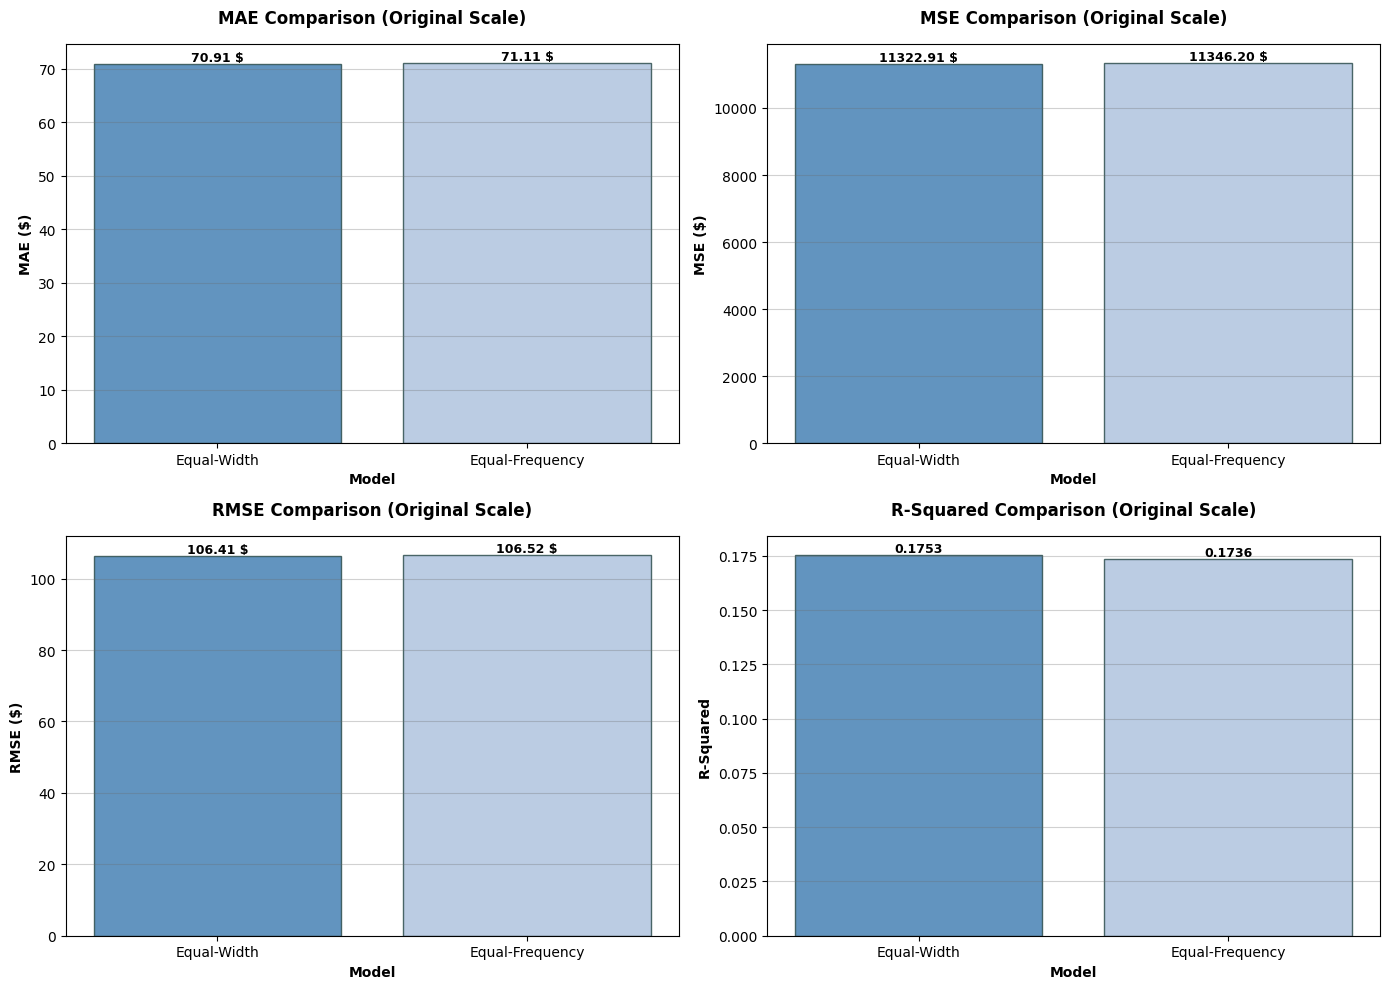

In [8]:
colors = ['steelblue', 'lightsteelblue']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['MAE', 'MSE', 'RMSE', 'R-Squared']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    x = np.arange(len(results))
    values = results[metric].values
    labels = results['Model'].values

    for i in range(len(values)):
        ax.bar(
            x[i],
            values[i],
            color=colors[i],
            edgecolor='darkslategray',
            alpha=0.85
        )
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    
    if metric in ['MAE', 'MSE', 'RMSE']:
        ax.set_ylabel(f'{metric} ($)', fontweight='bold')
    else:
        ax.set_ylabel(metric, fontweight='bold')

    ax.set_xlabel('Model', fontweight='bold')
    ax.set_title(f'{metric} Comparison (Original Scale)', fontweight='bold', fontsize=12, pad=15)
    
    ax.grid(axis='y', alpha=0.3, color='dimgray')
    
    for i, v in enumerate(values):
        if metric == 'R-Squared':
            label = f'{v:.4f}'
        else:
            label = f'{v:.2f} $'
        ax.text(
            x[i],
            v,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

plt.tight_layout()
plt.show()

In [9]:
results.to_csv('data/baseline_results.csv', index=False)
print("Baseline results saved to data/baseline_results.csv")

Baseline results saved to data/baseline_results.csv
